In [2]:
%load_ext autoreload
%autoreload 2

from collections import defaultdict
from pathlib import Path
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns
from tqdm import tqdm, trange
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA
from sklearn.manifold import MDS
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestCentroid, KNeighborsClassifier
from sklearn.metrics import roc_curve, RocCurveDisplay, auc, ConfusionMatrixDisplay
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.exceptions import ConvergenceWarning
from sklearn.base import clone
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

from modules.tracking import *
from modules.diff import *
from modules.feature_extraction import *
from modules.utils import *
from modules.visualize import *
from modules.model_selection import *

DATA_DIR = Path('./dataset')
FIGURE_DIR = Path('./figures')

DEBUG = False
ANIMATE_ALL = False


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
updrs_data = UPDRSdata(DATA_DIR/'motor_scales_all_2021.03.08.xlsx')
demographic_data = DemographicData(DATA_DIR/'demographics.xlsx')


In [4]:
df = demographic_data.original.copy()
df

,dx,age,education,sex,moca,handedness,dis.dur,updrs.1,updrs.2,updrs.3.off,updrs.3.on,hny
pidn,,,,,,,,,,,,
15669,pd,60,19,M,25,Ambidextrous,11,12,18,29,15.0,2
20190,pd,73,18,F,30,Right-handed,12,11,17,36,24.0,3
20452,pd,68,15,F,27,Right-handed,7,14,7,14,14.0,2
20462,parkinsonism,67,16,M,29,Right-handed,-99,15,30,27,NaN,3
20592,pd,70,24,F,30,Right-handed,9,19,13,30,25.0,2
20655,pd,65,16,M,27,Left-handed,7,7,8,32,5.0,3
20756,pd,70,18,F,29,Right-handed,17,17,8,31,21.0,2
21010,pd,71,18,F,30,Left-handed,10,7,43,47,41.0,-99
21987,pd,76,18,M,24,Right-handed,11,16,16,30,39.0,2


In [5]:
for c in df.columns:
    if c in ['dx', 'sex', 'handedness']:
        continue
    df[c][df[c]<0] = np.NaN

In [6]:
df

,dx,age,education,sex,moca,handedness,dis.dur,updrs.1,updrs.2,updrs.3.off,updrs.3.on,hny
pidn,,,,,,,,,,,,
15669,pd,60,19,M,25,Ambidextrous,11.0,12.0,18.0,29,15.0,2.0
20190,pd,73,18,F,30,Right-handed,12.0,11.0,17.0,36,24.0,3.0
20452,pd,68,15,F,27,Right-handed,7.0,14.0,7.0,14,14.0,2.0
20462,parkinsonism,67,16,M,29,Right-handed,NaN,15.0,30.0,27,NaN,3.0
20592,pd,70,24,F,30,Right-handed,9.0,19.0,13.0,30,25.0,2.0
20655,pd,65,16,M,27,Left-handed,7.0,7.0,8.0,32,5.0,3.0
20756,pd,70,18,F,29,Right-handed,17.0,17.0,8.0,31,21.0,2.0
21010,pd,71,18,F,30,Left-handed,10.0,7.0,43.0,47,41.0,NaN
21987,pd,76,18,M,24,Right-handed,11.0,16.0,16.0,30,39.0,2.0


array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'education'}>,
        <AxesSubplot:title={'center':'moca'}>],
       [<AxesSubplot:title={'center':'dis.dur'}>,
        <AxesSubplot:title={'center':'updrs.1'}>,
        <AxesSubplot:title={'center':'updrs.2'}>],
       [<AxesSubplot:title={'center':'updrs.3.off'}>,
        <AxesSubplot:title={'center':'updrs.3.on'}>,
        <AxesSubplot:title={'center':'hny'}>]], dtype=object)

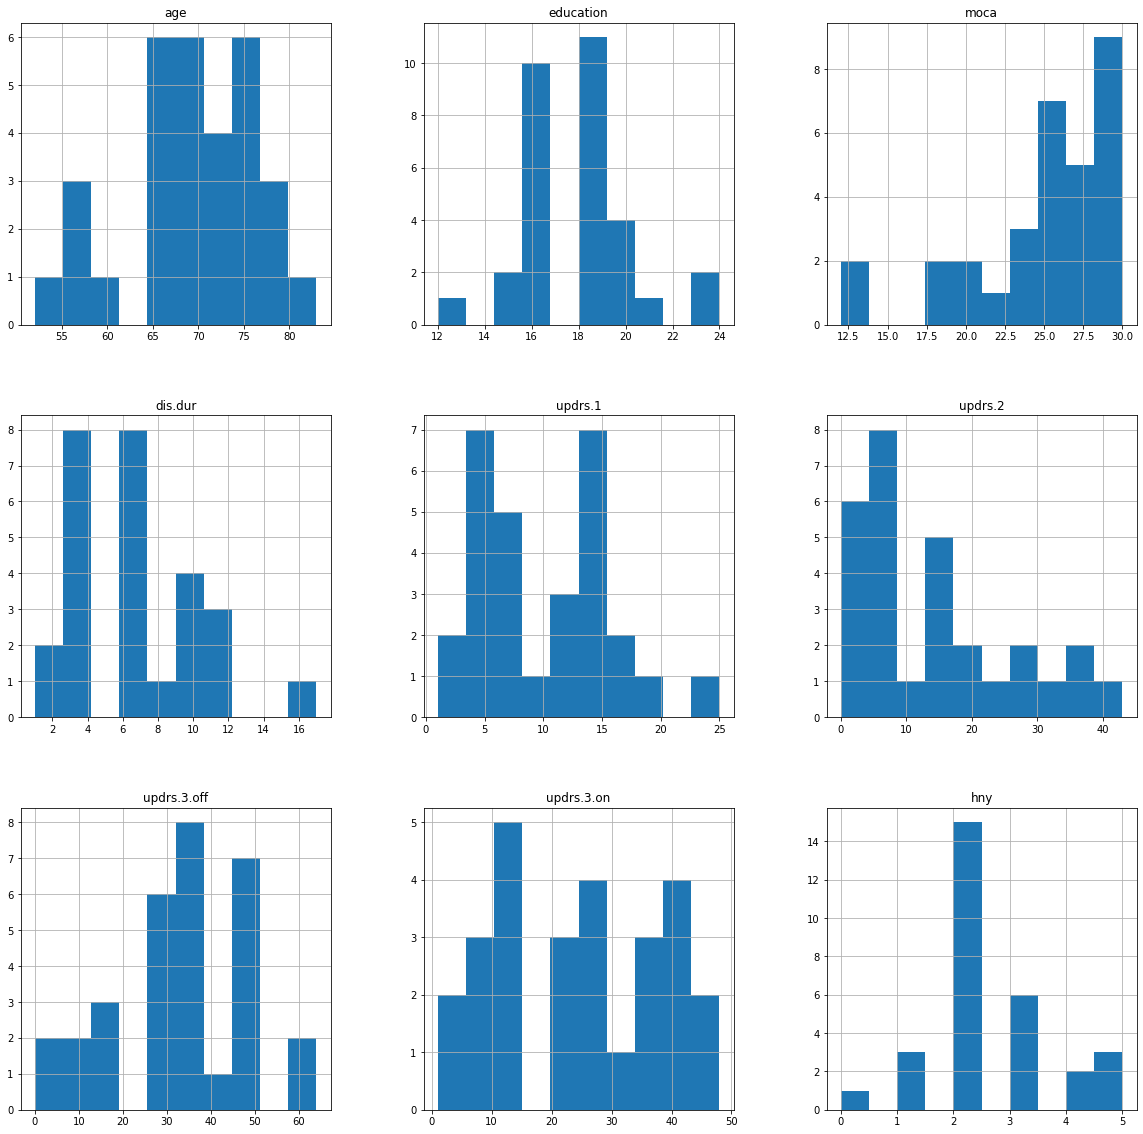

In [7]:
df.hist(figsize=(20,20))

In [8]:
df.describe()

,age,education,moca,dis.dur,updrs.1,updrs.2,updrs.3.off,updrs.3.on,hny
count,31.000000,31.000000,31.000000,27.000000,29.000000,29.000000,31.000000,27.000000,30.000000
mean,69.225806,17.741935,24.903226,6.666667,9.862069,14.551724,33.322581,24.592593,2.466667
std,7.246653,2.516184,4.874114,3.616203,5.780040,12.480231,16.108770,13.731657,1.195778
min,52.000000,12.000000,12.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,66.000000,16.000000,23.500000,4.000000,5.000000,5.000000,28.000000,14.000000,2.000000
50%,70.000000,18.000000,26.000000,6.000000,10.000000,10.000000,34.000000,25.000000,2.000000
75%,74.000000,18.500000,29.000000,9.000000,14.000000,21.000000,46.500000,36.500000,3.000000
max,83.000000,24.000000,30.000000,17.000000,25.000000,43.000000,64.000000,48.000000,5.000000


In [9]:
tmp1 = df.copy()
tmp1 = tmp1.drop(['updrs.3.on', 'updrs.3.off'], axis=1)
tmp1['medication.status'] = 'Off'
tmp1['updrs.3'] = df['updrs.3.off']

tmp2 = df.copy()
tmp2 = tmp2.drop(['updrs.3.on', 'updrs.3.off'], axis=1)
tmp2['medication.status'] = 'On'
tmp2['updrs.3'] = df['updrs.3.on']

split = pd.concat([tmp1, tmp2])

mild = split.loc[split['updrs.3']<33]
severe = split.loc[split['updrs.3']>=33]

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'education'}>,
        <AxesSubplot:title={'center':'moca'}>],
       [<AxesSubplot:title={'center':'dis.dur'}>,
        <AxesSubplot:title={'center':'updrs.1'}>,
        <AxesSubplot:title={'center':'updrs.2'}>],
       [<AxesSubplot:title={'center':'hny'}>,
        <AxesSubplot:title={'center':'updrs.3'}>, <AxesSubplot:>]],
      dtype=object)

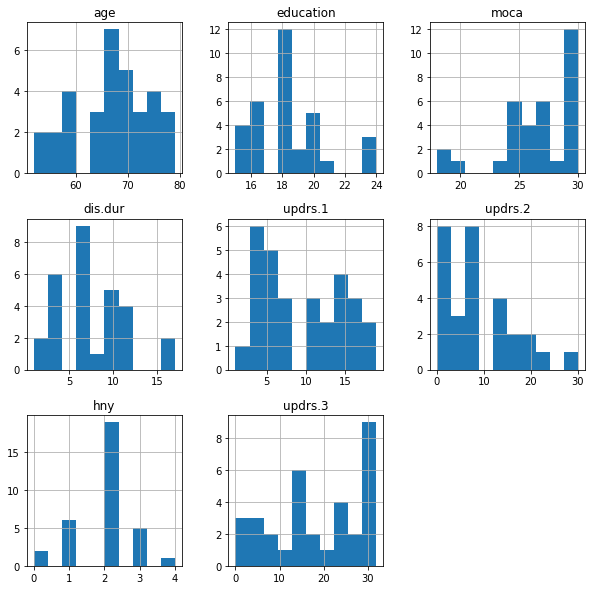

In [10]:
mild.hist(figsize=(10,10))

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'education'}>,
        <AxesSubplot:title={'center':'moca'}>],
       [<AxesSubplot:title={'center':'dis.dur'}>,
        <AxesSubplot:title={'center':'updrs.1'}>,
        <AxesSubplot:title={'center':'updrs.2'}>],
       [<AxesSubplot:title={'center':'hny'}>,
        <AxesSubplot:title={'center':'updrs.3'}>, <AxesSubplot:>]],
      dtype=object)

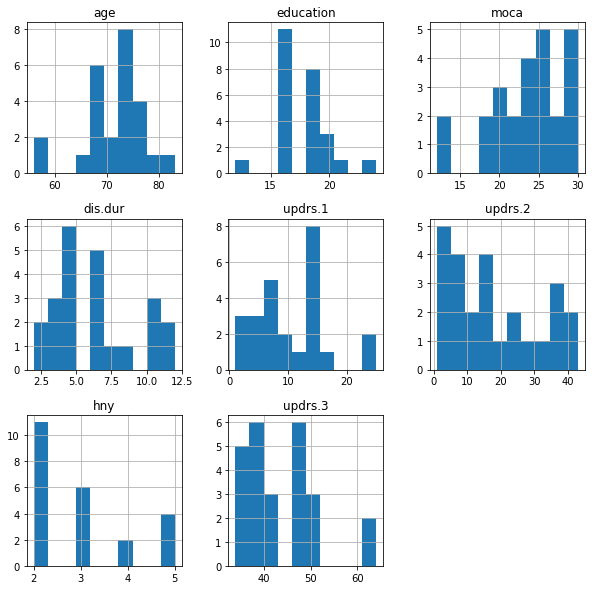

In [11]:
severe.hist(figsize=(10,10))

In [25]:
mild.describe()

,age,education,moca,dis.dur,updrs.1,updrs.2,hny,updrs.3
count,33.000000,33.000000,33.000000,29.000000,29.000000,29.000000,33.000000,33.000000
mean,67.121212,18.272727,26.515152,7.379310,9.448276,8.758621,1.909091,18.545455
std,7.385618,2.478315,3.192973,3.994763,5.382420,7.500739,0.842750,10.268553
min,52.000000,15.000000,18.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,65.000000,16.000000,25.000000,4.000000,5.000000,2.000000,2.000000,10.000000
50%,68.000000,18.000000,27.000000,7.000000,7.000000,8.000000,2.000000,19.000000
75%,71.000000,20.000000,29.000000,9.000000,14.000000,14.000000,2.000000,29.000000
max,79.000000,24.000000,30.000000,17.000000,19.000000,30.000000,4.000000,32.000000


In [26]:
severe.describe()

,age,education,moca,dis.dur,updrs.1,updrs.2,hny,updrs.3
count,25.000000,25.000000,25.000000,23.000000,25.00000,25.000000,23.000000,25.000000
mean,71.400000,17.480000,23.520000,5.869565,10.40000,18.440000,2.956522,43.400000
std,6.198118,2.329521,5.025933,2.989441,6.33114,13.684176,1.147260,8.231039
min,56.000000,12.000000,12.000000,2.000000,1.00000,1.000000,2.000000,34.000000
25%,69.000000,16.000000,20.000000,4.000000,6.00000,8.000000,2.000000,37.000000
50%,73.000000,18.000000,24.000000,6.000000,10.00000,16.000000,3.000000,41.000000
75%,74.000000,18.000000,28.000000,7.500000,14.00000,29.000000,3.500000,48.000000
max,83.000000,24.000000,30.000000,12.000000,25.00000,43.000000,5.000000,64.000000


In [17]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})


In [18]:
t, p = stats.ttest_ind(mild.drop(['dx', 'sex', 'handedness', 'medication.status'], axis=1), severe.drop(
    ['dx', 'sex', 'handedness', 'medication.status'], axis=1), nan_policy='omit')

print(p)

[0.023 0.221 0.008 0.138 0.553 0.002 0.000 0.000]


In [19]:
mild.drop(['dx', 'sex', 'handedness', 'medication.status'], axis=1).columns

Index(['age', 'education', 'moca', 'dis.dur', 'updrs.1', 'updrs.2', 'hny',
       'updrs.3'],
      dtype='object')

In [20]:
t, p = stats.mannwhitneyu(mild['dx', 'sex', 'handedness', 'medication.status'], severe.drop(
    ['dx', 'sex', 'handedness', 'medication.status'], axis=1), nan_policy='omit')

print(p)

[0.023 0.279 0.011 0.158 0.657 0.007 0.001 0.000]


In [23]:
t, p = stats.chisquare(mild.loc[:, ['dx', 'sex', 'handedness', 'medication.status']], severe.loc[:, ['dx', 'sex', 'handedness', 'medication.status']])

print(p)

ValueError: could not convert string to float: 'pd'